In [6]:
import SimpleITK as sitk
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
from scipy.fft import fft2

In [5]:
# load image
sitk_t1 = sitk.ReadImage('t1.nii.gz') 
t1 = sitk.GetArrayFromImage(sitk_t1)

# create slice for task 1-6
t1_slice = t1[0,0,45,:,:]
print(t1_slice.shape)

(256, 256)


In [32]:
# 1. Simulation of radial sampling: (15%)
spikes = 40
coord = sp.mri.radial([spikes,256,2],[256,256])

# calculate fourier transform of image
t1_slice_fft = sp.fft(t1_slice)

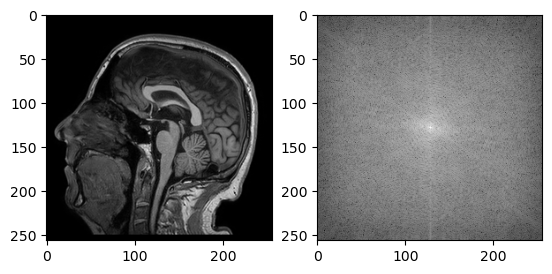

In [33]:
# plot data:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(t1_slice, cmap="gray")
axs[1].imshow(np.log10(abs(t1_slice_fft)), cmap="gray")
plt.show()